# TMS 道路清單轉換 (可行性研究) 分析報告結果

道路清單產出測試流程
* 透過 TMS動態熱區切出某一區 路網圖
* 從路網圖 切出節點
    * 每一條路網圖象徵一條道路(可能會有例外，例如起點與終點相同路網，這邊先單純測試)
    * 再由節點經過 TGOS API 轉換成地址
        * https://gist.motc.gov.tw/gist_api/swagger/ui/index
    * 由 起點(start pt)、終點(end pt)串成一條條道路地址清單

實作
* 透過

測試
* 道路清單是否符合實際需求
    * 結果
        * 
    

參考資料

* [save-start-end-points-in-another-shapefile-using-shapely](https://gis.stackexchange.com/questions/203134/save-start-end-points-in-another-shapefile-using-shapely)
   

---

#### 引入相關套件

In [ ]:
# 相關需要套件
import geopandas as gpd
import httplib2
import requests
import json
import csv
from shapely.geometry import Point, shape
import fiona

# 繪圖套件
%matplotlib inline

---

#### geopaandas 引入某一區 TMS動態熱區切出某一區 路網圖

In [477]:
import geopandas as gpd

# 匯入 TMS動態熱區切出某一區 路網圖
roadList=gpd.read_file('./roadInRangeSample.geojson',encoding='utf-8')

In [478]:
# 取得前五筆查看資料狀況
roadList.head()

# 都是 MULTILINESTRING 資料，代表還要轉成 LineString


,NAME,ALIAS,CLASS,INDEX,TYPE,RNAME,SNAME,LNAME,ANAME,FACILITY,STOP,LENGTH,geometry
0,精科路,精科路,6,None,1,精科路,None,None,None,None,None,838,"MULTILINESTRING ((120.59991 24.14267, 120.5999..."
1,中台路308巷,中台路308巷,6,None,1,中台路,None,308巷,None,None,None,68,"MULTILINESTRING ((120.59438 24.13933, 120.5943..."
2,建功路256巷,建功路256巷,6,None,1,建功路,None,256巷,None,None,None,84,"MULTILINESTRING ((120.60455 24.13624, 120.6045..."
3,文山路,文山路,6,None,1,文山路,None,None,None,None,None,238,"MULTILINESTRING ((120.60955 24.14451, 120.6093..."
4,精科中一路,精科中一路,6,None,1,精科中一路,None,None,None,None,None,1,"MULTILINESTRING ((120.58986 24.15050, 120.5899..."


In [480]:
# 要讀取裡頭每一欄透過此方法
roadList.iterrows()

# 搜尋
# 透過 for in 讀取每一欄
for i, row in roadList.iterrows():
    print('------------------')
    for polyline in row.geometry:
            print(polyline)

<generator object DataFrame.iterrows at 0x12f4b32d0>

(0, NAME                                                      精科路
ALIAS                                                     精科路
CLASS                                                       6
INDEX                                                    None
TYPE                                                        1
RNAME                                                     精科路
SNAME                                                    None
LNAME                                                    None
ANAME                                                    None
FACILITY                                                 None
STOP                                                     None
LENGTH                                                    838

In [484]:
# geopanda 資料其他取法
print(len(roadList['geometry'][0]))
print(row.geometry.type)

5
MultiLineString


#### 小結論
* 以此 路段 為例子就包含了 682 條路
* 一條 multi polyline 包含太多條 line
    * 代表說有重複點位狀況(蝴蝶結路段，起點終點相同)
    * 判斷道路清單上也會造成困難
* QGIS測試先切出線交集節點進行測試
    * 好處在於大量減少重複點位發生狀況
    * 缺點
        * 缺乏邊圍點位，還需要再度交集熱區 polygon 選出剩下點位
        * 必須仰賴套裝軟體，後續還是必須回到程式面找出交集點
    

---

#### 分析線交集節點

In [468]:
# 讀取交叉點位資料
lineIsPt=gpd.read_file('./lineIntersecPt.geojson',encoding='utf-8')

# 找出裏頭 xy
print(lineIsPt.geometry.x.head(2))
print(lineIsPt.geometry.y.head(2))

0    120.599907
1    120.601108
dtype: float64
0    24.142665
1    24.143069
dtype: float64


In [8]:
# 觀察資料
lineIsPt.head()

,NAME_1,NAME_2,geometry
0,精科路,培德路,POINT (120.59991 24.14267)
1,精科路,精科中路,POINT (120.60111 24.14307)
2,精科路,精科北路,POINT (120.60679 24.14802)
3,精科路,None,POINT (120.60018 24.14274)
4,精科路,精科東路,POINT (120.60111 24.14307)


#### Req 測試範例
* httplib2 傳送 GET 請求


In [11]:
# 取得 http
h = httplib2.Http()
# 打入 API 網址範例
url = 'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/23.5,122,5?$format=GEOJSON'
# 測試 req
resp, content = h.request(url)
# 印出結果
content

b'{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[121.6045812569886,23.509762481675281]},"properties":{"model":{"Addr":"\xe6\xbe\x8e\xe6\xb9\x96\xe7\xb8\xa3\xe9\xa6\xac\xe5\x85\xac\xe5\xb8\x82\xe5\xb1\xb1\xe6\xb0\xb4\xe9\x87\x8c\xe7\x8f\xa0\xe6\xb1\x9f600\xe8\x99\x9f"}}}]}'

##### 發現問題
* 回傳格式為 byte

* 回傳速度慢
    * 猜測API應該有阻檔或限制
    * 換另外一套套件進行測試

先檢驗速度

In [ ]:
# 換另外一操測試
# 引入 requests 模組
import requests
url = 'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/23.5,122,5?$format=GEOJSON'
# 使用 GET 方式下載普通網頁
r = requests.get(url)
print (r)

速度上一樣慢
* 有時甚至一筆十幾秒
* 猜測API應該有阻檔或限制

然而
* 但是某些情況下確實快的

最後結果
* 速度快慢依照資料精確度
* 符合 TGIS 搜尋規則，越精細資料越容易定位到


轉 byte 成 str

In [ ]:
# byte 轉 str 方法
str(content, encoding = "utf-8")

In [471]:
# 查看多少交叉點
len(lineIsPt.geometry)

444

In [ ]:
# 取出需要資料方便分析
container = []
for i in range(10):
    x = lineIsPt.geometry.x[i]
    y = lineIsPt.geometry.y[i]
    container.append([y,x])
    
print(container)


In [ ]:
# 一次轉換十筆進行測試

for i in range(10):
    x = str(lineIsPt.geometry.x[i])
    y = str(lineIsPt.geometry.y[i])
    
    xy = y+','+x
    res = f'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/{xy}?$format=GEOJSON'
    container.append(res)

# 觀察    
container

In [72]:
# 檢查資料
lineIsPt.head()

,NAME_1,NAME_2,geometry
0,精科路,培德路,POINT (120.59991 24.14267)
1,精科路,精科中路,POINT (120.60111 24.14307)
2,精科路,精科北路,POINT (120.60679 24.14802)
3,精科路,None,POINT (120.60018 24.14274)
4,精科路,精科東路,POINT (120.60111 24.14307)


#### 轉換大量資料時遇到超時問題

引入 socket 解決

```python
socket.setdefaulttimeout(100000000)
```

#### 打API轉換大量資料

In [476]:
socket.setdefaulttimeout(100000000)

h = httplib2.Http(timeout=None)

container = []

# for i in range(10):
for i in range(lineIsPt.index.stop):
    x = str(lineIsPt.geometry.x[i])
    y = str(lineIsPt.geometry.y[i])
    xy = y+','+x
    resUrl = f'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/{xy}?$format=GEOJSON'
    res, content = h.request(resUrl)
    container.append(json.loads(str(content, encoding = "utf-8")))

# 查看    
container
print(len(container)) #10
print(type(container)) #<class 'list'>

# 發現 5條路變成 10 個點
# 合理 -> 一條路有兩個節點(頭尾)

# 重組結果資料
myResData = []

for i in container:
    myResData.append([
        i['features'][0]['geometry']['coordinates'][0],
        i['features'][0]['geometry']['coordinates'][1],
        i['features'][0]['properties']['model']['Addr']
    ])

# 觀察結果資料
print(myResData[0],myResData[-1])
print(type(myResData[0]))

In [55]:
# 查看逐筆結果資料
for i in myResData:
    print(i[0], i[1], i[2]) 

120.5996308508481 24.14229158797876 台中市南屯區春社里培德路7號
120.6009109336114 24.14252298118082 台中市南屯區春社里精科路2號
120.6062307321551 24.14751725360878 台中市南屯區文山里精科路28號
120.5996308508481 24.14229158797876 台中市南屯區春社里培德路7號
120.6009109336114 24.14252298118082 台中市南屯區春社里精科路2號
120.6062307321551 24.14751725360878 台中市南屯區文山里精科路28號
120.6082305515638 24.14873859268674 台中市南屯區文山里精科路112號
120.5943328215131 24.13940972800623 台中市南屯區春社里中台路310巷1之1號
120.6042334419134 24.136863556312 台中市南屯區春社里建功路256巷22號
120.6042334419134 24.136863556312 台中市南屯區春社里建功路256巷22號


#### 將 444 個節點計算出來並存成 csv 方便後續檢驗

In [113]:
import csv

# 開啟輸出的 CSV 檔案
with open('addressRes.csv', 'w', newline='') as csvfile:
    # 建立 CSV 檔寫入器
    writer = csv.writer(csvfile)
    # 寫入第一列資料
    writer.writerow(['Lon', 'Lat', 'Address'])
    
    #迴圈寫入資料
    for i in myResData:
        writer.writerow([i[0], i[1], i[2]])    

#### 小結論
* 透過節點資料打 TGOS API 取得地址清單
* 觀察資料歸納
    * 時間問題
        * 結果 time out 問題
        * 再更多時可能會有 非同步 問題
    * 節點問題
        * 只有交叉點，沒有路尾點
        * 依然仰賴套裝軟體抓取
* 存成 CSV 以利後續分析

---

#### 嘗試透過 shapely + fiona 直接抓取:
* 起始點
* 結束點
* 中間節點

* 為了解決節點問題，包含：
    * 只有交叉點，沒有路尾點
    * 依然仰賴套裝軟體抓取
    

In [115]:
from shapely.geometry import Point, shape
import fiona

In [489]:
# 透過 fiona xy 取出 
# 目的是直接組成 shapely 格式
lines = [
    shape(line['geometry']) 
    for line in fiona.open("roadInRangeSample.geojson")
]

# 查看前五筆
lines[0:5]

In [492]:
# 都是 multi
# 雙層才能取回逐一的路段
for i in lines:
    for line in i:
        print(line)

LINESTRING (120.599907445659 24.14266516824731, 120.5999913549021 24.14268805430268, 120.6001757311819 24.14274498918141, 120.600254656112 24.1427693608955, 120.600459524787 24.14280751856759, 120.601107510771 24.14306928214556)
LINESTRING (120.601107510771 24.14306928214556, 120.601575084762 24.14333258754232, 120.6017854075629 24.14366336177752, 120.6020297277266 24.14408333324709, 120.6023645507882 24.14479183179674, 120.6026486578022 24.14527742673277, 120.6029045858159 24.14563976883985, 120.6031891902935 24.14596549286116, 120.6034568048691 24.14624399703564, 120.6037415888613 24.14651206234614, 120.6042887249221 24.146914470374, 120.6047277906611 24.14716720840664, 120.6050757527902 24.1473253591294, 120.6055378958349 24.14750477104731, 120.6061884477823 24.14771611854459, 120.6065251326042 24.1478270617065, 120.6067864506869 24.148021048935)

In [493]:
# 取出 路的起點、終點
endpts = [
    (
        Point(list(line.coords)[0]),
        Point(list(line.coords)[-1])
    )
    # 先取出 multiline     
    for multiLines in lines
    # 再從 multiLine 取出各條路
    for line in multiLines
]

In [497]:
# 查看多少個點
print(len(endpts))

# 查看格式
print(endpts[0:5])

682
[(<shapely.geometry.point.Point object at 0x12ee36490>, <shapely.geometry.point.Point object at 0x12ee36750>), (<shapely.geometry.point.Point object at 0x12f465410>, <shapely.geometry.point.Point object at 0x12f49a950>), (<shapely.geometry.point.Point object at 0x12ee36990>, <shapely.geometry.point.Point object at 0x12ee36c50>), (<shapely.geometry.point.Point object at 0x12e765750>, <shapely.geometry.point.Point object at 0x12ab5ea50>), (<shapely.geometry.point.Point object at 0x12e765290>, <shapely.geometry.point.Point object at 0x12ee36250>)]


每一個起點、終點都組成一個 list 
也形成每一段道路清單

In [145]:
endpts[0]

(<shapely.geometry.point.Point at 0x128965b50>,
 <shapely.geometry.point.Point at 0x1289657d0>)

#### 小結論
* 透過 shapely + fiona 解決節點問題
    * 抓取 交叉點、起點、終點
    * 完整 程式流程 抓取而不仰賴套裝軟體
* 問題
    * 太多 multi line 使得整體狀況仍顯得複雜
        * 嘗試透過更簡單的線段進行分析
    * 此外，透過 API 回傳的地址到底準不準?影響後續要給的道路清單
    * 這邊也嘗試進行檢驗

---

#### 取出簡單線段進行檢驗
* 用單純線嘗試

In [498]:
import geopandas as gpd

# 引入簡單線段
singleRoad=gpd.read_file('./singleRoadExample.geojson',encoding='utf-8')

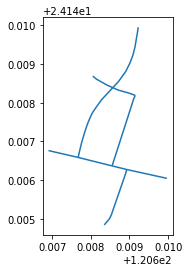

In [248]:
# 檢查形狀
singleRoad.plot()

In [499]:

from shapely.geometry import Point, shape
import fiona

# 除了取出 xy，更取出原始道路名稱以利後面比對
lines = [[line['properties']['NAME'],shape(line['geometry'])] for line in fiona.open("./singleRoadExample.geojson")]
# 變成 shapely 格式
lines

[['保安八街', <shapely.geometry.multilinestring.MultiLineString at 0x12dd11550>],
 ['保安十街', <shapely.geometry.multilinestring.MultiLineString at 0x12dd11250>],
 ['保安九街', <shapely.geometry.multilinestring.MultiLineString at 0x12e839e50>],
 ['文山五街', <shapely.geometry.multilinestring.MultiLineString at 0x12ead7950>],
 ['文山三街', <shapely.geometry.multilinestring.MultiLineString at 0x12e839bd0>]]

##### 目標：組成 geopandas data frame 以利後續分析

In [264]:
# 測試
import geopandas as gpd

# 從 geopandas 格式觀察 geometry 格式
lines_geopandas=gpd.read_file('./singleRoadExample.geojson',encoding='utf-8')

print(lines_geopandas.head(3))

# 此時取出的 geometry 就是 shapely 格式
for i in lines_geopandas['geometry'][0]:
    # shapely.geometry.linestring.LineString'
    print(type(i))

   NAME ALIAS  CLASS INDEX  TYPE RNAME SNAME LNAME ANAME FACILITY  STOP  \
0  保安八街  保安八街      6  None     1  保安八街  None  None  None     None  None   
1  保安十街  保安十街      6  None     1  保安十街  None  None  None     None  None   
2  保安九街  保安九街      6  None     1  保安九街  None  None  None     None  None   

   LENGTH                                           geometry  
0     156  MULTILINESTRING ((120.60893 24.14627, 120.6088...  
1     189  MULTILINESTRING ((120.60923 24.14995, 120.6092...  
2     211  MULTILINESTRING ((120.60855 24.14637, 120.6085...  
<class 'shapely.geometry.linestring.LineString'>


In [310]:
# 測試
# 如何添加 panda dataframe 格式

df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

print(df)
print("=========================")

# 新增欄位
test = pd.DataFrame({
    "City": ["Test"],
    "Country": ["Test"],
    "Latitude":  [132.311],
    "Longitude": [23.243242],
})

df = df.append(test)
print(df)

           City    Country  Latitude  Longitude
0  Buenos Aires  Argentina    -34.58     -58.66
1      Brasilia     Brazil    -15.78     -47.91
2      Santiago      Chile    -33.45     -70.66
3        Bogota   Colombia      4.60     -74.08
4       Caracas  Venezuela     10.48     -66.86
           City    Country  Latitude  Longitude
0  Buenos Aires  Argentina   -34.580 -58.660000
1      Brasilia     Brazil   -15.780 -47.910000
2      Santiago      Chile   -33.450 -70.660000
3        Bogota   Colombia     4.600 -74.080000
4       Caracas  Venezuela    10.480 -66.860000
0          Test       Test   132.311  23.243242


* 由於 geoDataFrames 就是以 Shapely 進行儲存
* 故這邊繼續以 Shapely 進行處理

先將 multi 轉成 single 並且取出節點

In [500]:
# 取出各條路及其節點

endpts = [[
    multiLines[0],
    (     
        # 再加入是哪一條線
        # 每一個起始、終點湊成一條路就是一個單位
        Point(list(line.coords)[0]),
        Point(list(line.coords)[-1])
     )
    ]
    # 先取出 multiline     
    for multiLines in lines
    # 再從 multiLine 取出各條路
    for line in multiLines[1]
]

# 得到起始點、結束點、原始道路名稱 list
endpts

[['保安八街',
  (<shapely.geometry.point.Point at 0x12ee2b290>,
   <shapely.geometry.point.Point at 0x12ec7d1d0>)],
 ['保安十街',
  (<shapely.geometry.point.Point at 0x12ee2bb90>,
   <shapely.geometry.point.Point at 0x12dea0910>)],
 ['保安九街',
  (<shapely.geometry.point.Point at 0x12ee2b3d0>,
   <shapely.geometry.point.Point at 0x12ec7d990>)],
 ['文山五街',
  (<shapely.geometry.point.Point at 0x12e731a90>,
   <shapely.geometry.point.Point at 0x12ec7d8d0>)],
 ['文山三街',
  (<shapely.geometry.point.Point at 0x12e2e8b50>,
   <shapely.geometry.point.Point at 0x12e2e83d0>)]]

##### panda DataFrame 新增欄位方式

* 道路節點資料表結構定義

```python
gpd_test = gpd.GeoDataFrame({
    "Road_Index": index
    "Geometry": endpts[0]
})
```

In [378]:
# 組成 道路節點 GeoDataFrame
index = 0
gpd_road_nodes = gpd.GeoDataFrame()

# 資料欄位定義
for pt in endpts:
    pt = gpd.GeoDataFrame({
        "Road_Index": index,
        "Road_Name":pt[0],
        "geometry": pt[1]
    })
    
    gpd_road_nodes = gpd_road_nodes.append(pt)
    index += 1
gpd_road_nodes

,Road_Index,Road_Name,geometry
0,0,保安八街,POINT (120.60893 24.14627)
1,0,保安八街,POINT (120.60835 24.14484)
0,1,保安十街,POINT (120.60923 24.14995)
1,1,保安十街,POINT (120.60767 24.14659)
0,2,保安九街,POINT (120.60855 24.14637)
1,2,保安九街,POINT (120.60915 24.14819)
0,3,文山五街,POINT (120.60805 24.14869)
1,3,文山五街,POINT (120.60915 24.14819)
0,4,文山三街,POINT (120.60691 24.14677)
1,4,文山三街,POINT (120.60997 24.14605)


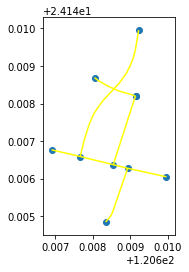

In [504]:
# 繪製取得節點並且查看是否對應道路
road = singleRoad.plot(color="yellow")
gpd_road_nodes.plot(ax=road)

結果完全對應

#### 小結論
* 為了確認取得的節點是否真的是我們要的
* 這邊進行了一系列轉換最後透過 gpd 呈現發現完全一致

* 問題：
    * 透過 API 回傳的地址到底準不準?
        * 影響後續給的清單

---